## Import Library

In [49]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [50]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [51]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

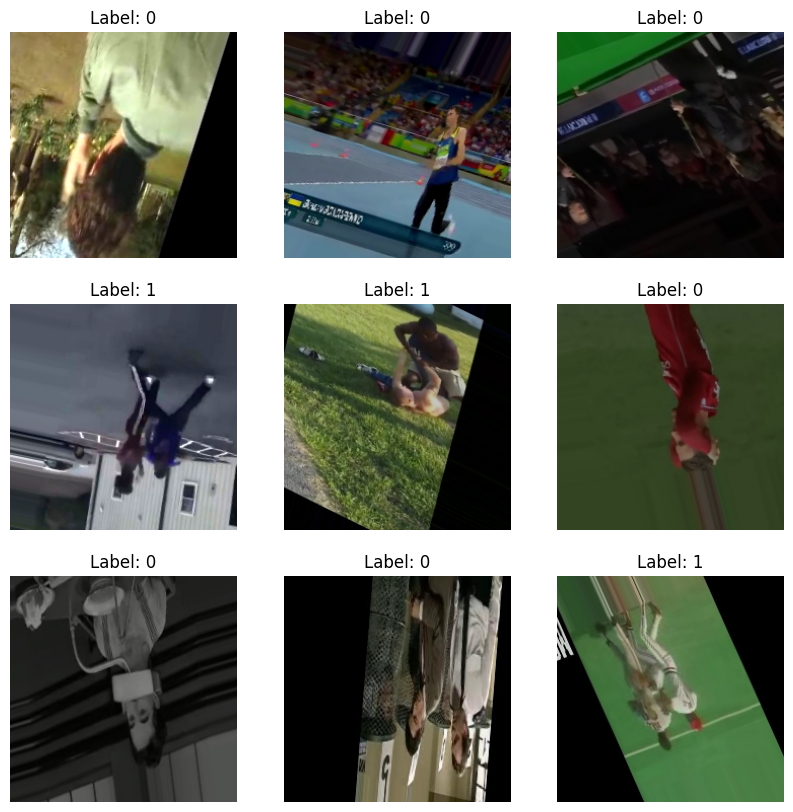

In [52]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [53]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# All Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_AllFreeze_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [54]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5293 - loss: 1.5023
Epoch 1: val_accuracy improved from -inf to 0.53409, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 675ms/step - accuracy: 0.5302 - loss: 1.4999 - val_accuracy: 0.5341 - val_loss: 1.1504
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6515 - loss: 1.2374
Epoch 2: val_accuracy improved from 0.53409 to 0.72500, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.6516 - loss: 1.2369 - val_accuracy: 0.7250 - val_loss: 1.0867
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.6947 - loss: 1.1223
Epoch 3: val_accuracy improved from 0.72500 to 0.77500, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 657ms/step - accuracy: 0.6947 - loss: 1.1223 - val_accuracy: 0.7750 - val_loss: 1.0273
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6986 - loss: 1.1108
Epoch 4: val_accuracy improved from 0.77500 to 0.79545, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 636ms/step - accuracy: 0.6989 - loss: 1.1102 - val_accuracy: 0.7955 - val_loss: 0.9732
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6991 - loss: 1.0542
Epoch 5: val_accuracy improved from 0.79545 to 0.82045, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 670ms/step - accuracy: 0.6996 - loss: 1.0536 - val_accuracy: 0.8205 - val_loss: 0.9167
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7122 - loss: 1.0274
Epoch 6: val_accuracy improved from 0.82045 to 0.83636, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.7121 - loss: 1.0273 - val_accuracy: 0.8364 - val_loss: 0.8645
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.6975 - loss: 1.0206
Epoch 7: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 637ms/step - accuracy: 0.6978 - loss: 1.0203 - val_accuracy: 0.8318 - val_loss: 0.8162
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7399 - loss: 0.9339
Epoch 8: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 626ms/step - accuracy: 0.7401 - loss: 0.9338 - val_accuracy: 0.8273 - val_loss: 0.7728
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7818 - loss: 0.8782
Epoch 9: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 635ms/step - accuracy: 0.7815 - loss: 0.8784 - val_accuracy: 0.8250 - val_loss: 0.7464
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.7513 - loss: 0.9054
Epoch 10: val_accuracy did not

49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - accuracy: 0.7684 - loss: 0.8757 - val_accuracy: 0.8545 - val_loss: 0.7017
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7711 - loss: 0.9120
Epoch 12: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step - accuracy: 0.7711 - loss: 0.9117 - val_accuracy: 0.8455 - val_loss: 0.6978
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7507 - loss: 0.9150
Epoch 13: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 630ms/step - accuracy: 0.7508 - loss: 0.9147 - val_accuracy: 0.8364 - val_loss: 0.6873
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7593 - loss: 0.8684
Epoch 14: val_accuracy improved from 0.85455 to 0.85682, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 626ms/step - accuracy: 0.7594 - loss: 0.8684 - val_accuracy: 0.8568 - val_loss: 0.6745
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.7664 - loss: 0.8882
Epoch 15: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 625ms/step - accuracy: 0.7664 - loss: 0.8879 - val_accuracy: 0.8455 - val_loss: 0.6645
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7862 - loss: 0.8212
Epoch 16: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.7861 - loss: 0.8218 - val_accuracy: 0.8523 - val_loss: 0.6593
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.7814 - loss: 0.8330
Epoch 17: val_accuracy improved from 0.85682 to 0.85909, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 610ms/step - accuracy: 0.7815 - loss: 0.8327 - val_accuracy: 0.8591 - val_loss: 0.6618
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7730 - loss: 0.8248
Epoch 18: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 616ms/step - accuracy: 0.7731 - loss: 0.8244 - val_accuracy: 0.8523 - val_loss: 0.6459
Epoch 19/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7829 - loss: 0.8245
Epoch 19: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 602ms/step - accuracy: 0.7831 - loss: 0.8244 - val_accuracy: 0.8568 - val_loss: 0.6333
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7730 - loss: 0.8190
Epoch 20: val_accuracy improved from 0.85909 to 0.86136, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.7729 - loss: 0.8192 - val_accuracy: 0.8614 - val_loss: 0.6255
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7896 - loss: 0.7840
Epoch 21: val_accuracy improved from 0.86136 to 0.86591, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.7898 - loss: 0.7839 - val_accuracy: 0.8659 - val_loss: 0.6309
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8011 - loss: 0.7825
Epoch 22: val_accuracy did not improve from 0.86591
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.8011 - loss: 0.7824 - val_accuracy: 0.8591 - val_loss: 0.6169
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7903 - loss: 0.7898
Epoch 23: val_accuracy did not improve from 0.86591
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.7904 - loss: 0.7897 - val_accuracy: 0.8614 - val_loss: 0.6217
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.7983 - loss: 0.7635
Epoch 24: val_accuracy did not improve from 0.86591
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 612ms/step - accuracy: 0.7983 - loss: 0.7636 - val_accuracy: 0.8545 - val_loss: 0.6187
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7970 - loss: 0.7654
Epoch 25: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 616ms/step - accuracy: 0.7928 - loss: 0.7834 - val_accuracy: 0.8682 - val_loss: 0.6045
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7995 - loss: 0.7474
Epoch 29: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 610ms/step - accuracy: 0.7996 - loss: 0.7474 - val_accuracy: 0.8614 - val_loss: 0.5971
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7975 - loss: 0.7797
Epoch 30: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.7977 - loss: 0.7792 - val_accuracy: 0.8682 - val_loss: 0.5816
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8212 - loss: 0.7133
Epoch 31: val_accuracy improved from 0.86818 to 0.87273, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 625ms/step - accuracy: 0.8212 - loss: 0.7135 - val_accuracy: 0.8727 - val_loss: 0.5771
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8243 - loss: 0.6985
Epoch 32: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 629ms/step - accuracy: 0.8242 - loss: 0.6988 - val_accuracy: 0.8727 - val_loss: 0.5763
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8276 - loss: 0.7216
Epoch 33: val_accuracy improved from 0.87273 to 0.87955, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 625ms/step - accuracy: 0.8275 - loss: 0.7218 - val_accuracy: 0.8795 - val_loss: 0.5641
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8211 - loss: 0.7197
Epoch 34: val_accuracy improved from 0.87955 to 0.88182, saving model to NoMCLAHE_AllFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 632ms/step - accuracy: 0.8209 - loss: 0.7199 - val_accuracy: 0.8818 - val_loss: 0.5664
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8071 - loss: 0.7191
Epoch 35: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 619ms/step - accuracy: 0.8071 - loss: 0.7193 - val_accuracy: 0.8659 - val_loss: 0.5783
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8402 - loss: 0.6815
Epoch 36: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 623ms/step - accuracy: 0.8401 - loss: 0.6815 - val_accuracy: 0.8659 - val_loss: 0.5840
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8382 - loss: 0.6639
Epoch 37: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 617ms/step - accuracy: 0.8381 - loss: 0.6639 - val_accuracy: 0.8727 - val_loss: 0.5825
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8158 - loss: 0.7055
Epoch 38: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.8507 - loss: 0.6468 - val_accuracy: 0.8864 - val_loss: 0.5588
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8521 - loss: 0.6212
Epoch 50: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.8519 - loss: 0.6215 - val_accuracy: 0.8727 - val_loss: 0.5489


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8582 - loss: 0.6010
Validation Loss: 0.5488983392715454
Validation Accuracy: 0.8727272748947144


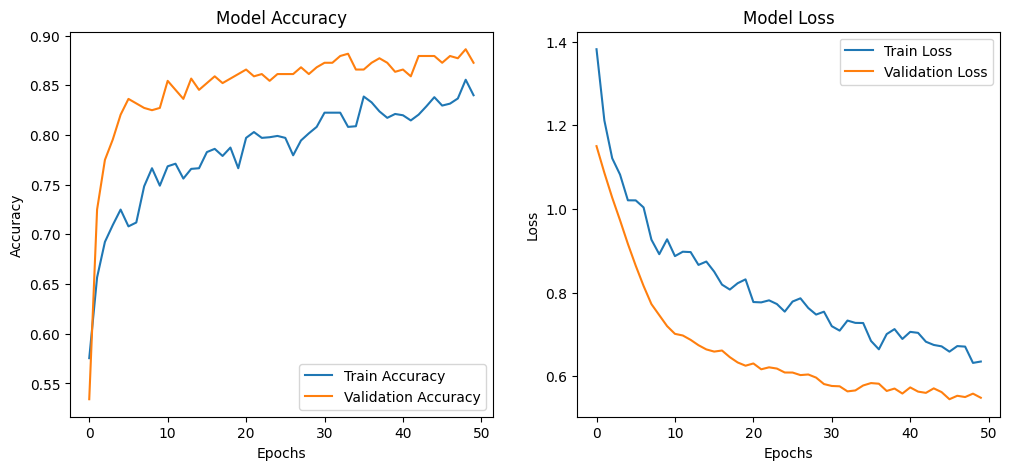

In [55]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [56]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_AllFreeze_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8064 - loss: 0.7332
Test Accuracy : 87.84%
Test Loss     : 0.582


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


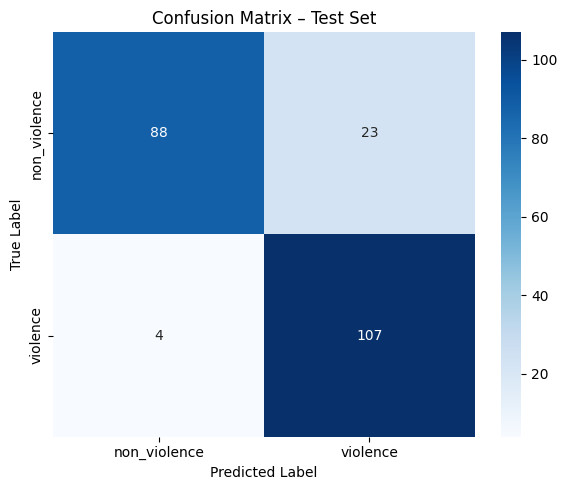


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.96      0.79      0.87       111
    violence       0.82      0.96      0.89       111

    accuracy                           0.88       222
   macro avg       0.89      0.88      0.88       222
weighted avg       0.89      0.88      0.88       222



In [57]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))